In [1]:
import wandb
from datetime import datetime

In [3]:
lr = 1e-4
batch_size = 64
wd = 1e-5
pos_weight = 2
image_size = 256
# backbone="segmentation"
backbone="none"
vertical_type = "sagittal"
train_portion = 0.5
milestones = [50, 100, 150, 200]
model_name = "eff_v2"

slice_range=5

In [3]:
wandb_entity='longyi'

wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "pos_weight" : pos_weight,
    "backbone" : backbone,
    "image_size" : image_size,
})
wandb.run.name = f'{vertical_type}_{model_name}_c2_center_' + datetime.now().strftime("%H%M%S")
wandb.run.name

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'sagittal_eff_v2_c2_center_215515'

In [4]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math
from tqdm import tqdm
import random
from sklearn.utils import shuffle
from sklearn import metrics
from PIL import Image, ImageOps

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
pos_weight = torch.tensor(pos_weight)

In [6]:
# DATA_DIR = "/media/longyi/SSD9701/"
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

IMAGES_DIR = os.path.join(DATA_DIR, f"train_{vertical_type}_images_jpeg95")
LABEL_DIR = os.path.join(DATA_DIR, f"segmentation_{vertical_type}_labels")
MASK_DIR = os.path.join(DATA_DIR, "train_sagittal_labels_jpeg95")



In [7]:
df = pd.read_csv(os.path.join(DATA_DIR, 'meta_sagittal_c2_center.csv')).set_index("UID")
print(len(df))
df.head()

2011


,C2,C2_cross_fracture,sagittal_center_slice,label_scale,left,top,right,bottom
UID,,,,,,,,
1.2.826.0.1.3680043.10001,0,1,281,32,49,98,377,590
1.2.826.0.1.3680043.10005,0,1,255,32,22,0,366,291
1.2.826.0.1.3680043.10014,0,1,261,32,28,148,480,882
1.2.826.0.1.3680043.10016,1,0,278,32,37,98,396,601
1.2.826.0.1.3680043.10032,0,1,250,32,28,125,413,584


In [8]:
df = shuffle(df)

In [9]:
pos_df = df[(df.C2 == 1) & (df.C2_cross_fracture == 1)]
neg_df = df[(df.C2 == 0)]
print(len(pos_df), len(neg_df))

136 1730


In [10]:
# df = pd.concat((pos_df, neg_df.iloc[:len(pos_df) * ]))

df = pd.concat((pos_df, neg_df))
print(len(df))
df.head()

1866


,C2,C2_cross_fracture,sagittal_center_slice,label_scale,left,top,right,bottom
UID,,,,,,,,
1.2.826.0.1.3680043.10776,1,1,250,32,177,37,399,463
1.2.826.0.1.3680043.14740,1,1,244,32,13,6,335,318
1.2.826.0.1.3680043.25071,1,1,216,32,40,83,304,330
1.2.826.0.1.3680043.8907,1,1,255,32,176,86,434,623
1.2.826.0.1.3680043.11757,1,1,258,32,92,70,411,439


1
(369, 319, 3)


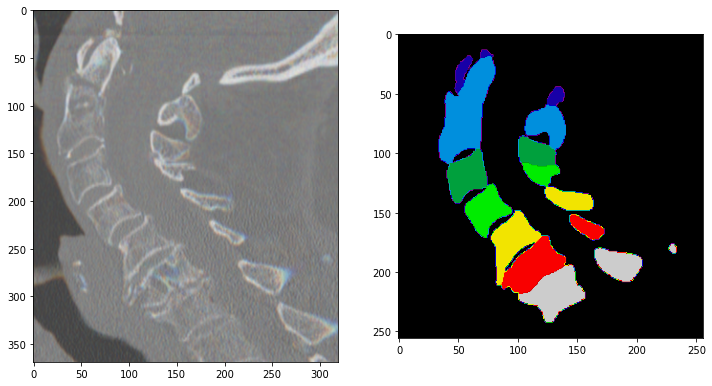

In [11]:
class SagittalDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, transform=None):
        super().__init__()

        self.df = df
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.df) * slice_range

    def __getitem__(self, idx):
        s = self.df.iloc[idx // 5]
        UID = s.name
        
        center_slice = s.sagittal_center_slice + (idx % slice_range) - int(slice_range // 2)
        
        r = Image.open(os.path.join(self.image_dir, UID, f"{center_slice-1}.jpeg"))
        g = Image.open(os.path.join(self.image_dir, UID, f"{center_slice-0}.jpeg"))
        b = Image.open(os.path.join(self.image_dir, UID, f"{center_slice+1}.jpeg"))
        img = Image.merge('RGB', (r, g, b))
        
        
        img = TF.crop(img, s.top, s.left, s.bottom - s.top, s.right - s.left)

        mask = Image.open(os.path.join(self.mask_dir, UID, f"{center_slice}.png"))

        label = s.C2 & s.C2_cross_fracture

        if self.transform:
            img, mask, label = self.transform(img, mask, label)

        return img, mask, label


dataset = SagittalDataset(df, IMAGES_DIR, MASK_DIR)
img, mask, label = dataset[20]

_, axs = plt.subplots(1, 2, figsize=(12, 12))
print(label)
axs[0].imshow(img)

axs[1].imshow(mask, cmap="nipy_spectral")

print(np.asarray(img).shape)
# axs[1].axhline(126)
# axs[1].axvline(125)

In [12]:
class DataTransform(nn.Module):
    def __init__(self, image_size, train=True):
        super().__init__()
        self.train = train
       
        transform = [T.Resize(image_size)]
        if self.train:
            transform.append(T.RandomAutocontrast())
        
        self.transform = T.Compose(transform + [
            T.ToTensor(), 
            T.Normalize(0.5, 0.5)
        ])

        self.mask_transform = T.Compose([
            T.Resize(image_size, interpolation=torchvision.transforms.InterpolationMode.NEAREST),
            T.PILToTensor(),
            T.Lambda(lambda x: x.float()),
            T.Normalize(0, 32)
        ])

        # self.label_transform = T.ToTensor()

    def forward(self, x, mask, label):
        
        
        
        x = TF.center_crop(x, max(x.width, x.height))
        
        if self.train:
            random_rotation_angle = np.random.randint(-15, 15)
            x = TF.rotate(x, random_rotation_angle)
            mask = TF.rotate(mask, random_rotation_angle)
        
        
        x = self.transform(x)

        # print(mask)
        mask = self.mask_transform(mask)
        
        # simple model
        mask[mask != 0.25] = 0
        mask[mask > 0] = 1

        label = torch.tensor(label).long()
        return x, mask, label


transform = DataTransform(image_size, train=True)
val_transform = DataTransform(image_size, train=False)

In [13]:
def split_dataset(df, train_portion=0.5):
    df = shuffle(df)
    train_end_index = int(len(df) * train_portion)
    train_df = df.iloc[:train_end_index]
    val_df = df.iloc[train_end_index:]
    return train_df, val_df

In [14]:
train_df, val_df = split_dataset(df, train_portion)
print(len(train_df), len(val_df))

933 933


In [15]:
train_dataset = SagittalDataset(train_df, IMAGES_DIR, MASK_DIR, transform=transform)
val_dataset = SagittalDataset(val_df, IMAGES_DIR, MASK_DIR, transform=val_transform)
img, mask, label = train_dataset[1]
print(img.shape)
print(label)
print(mask.shape)
mask.max()

torch.Size([3, 256, 256])
tensor(0)
torch.Size([1, 256, 256])


tensor(1.)

In [16]:
def get_backbone():
    backbone = models.resnet50(pretrained=True)
    conv1_weight = backbone.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    backbone.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return nn.ModuleList([
        nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool),
        nn.Sequential(
            backbone.layer1,
            backbone.layer2,
        ),
        backbone.layer3,
        backbone.layer4
    ]), [1, 64, 512, 1024, 2048]

# backbone, channels = get_backbone()
# print(backbone)

In [17]:
class ClassificationModel(nn.Module):
    def __init__(self, backbone, channels, spine=2, deep=4):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.register_buffer('spine', torch.tensor(spine))
        self.dw = nn.Parameter(torch.tensor(20.0, dtype=torch.float), requires_grad=False)
        # self.register_buffer('mf', (torch.tensor(spine) * 0.125).reshape(1, 1, 1))
        self.init_layers()

    def init_layers(self):
        self.parallel_modules_1 = self.make_parallel_modules()
        self.parallel_modules_2 = self.make_parallel_modules()
        self.downsampling_modules = self.make_downsampling_modules()
        self.mask_modules = self.make_mask_modules()
        self.classification_modules = self.make_classification_modules()

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for channel in self.channels:
            module = nn.Conv2d(channel, channel, kernel_size=1, padding='same')
            parallel_modules.append(module)

        return parallel_modules

    def make_mask_modules(self):
        mask_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                # nn.Conv2d(self.channels[i], self.channels[i+1], kernel_size=3, stride=2, padding=1),
                # nn.Sigmoid()
                nn.MaxPool2d(3, stride=2, padding=1)
            )
            mask_modules.append(module)

        return mask_modules

    def make_downsampling_modules(self):
        downsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i + 1], kernel_size=3, stride=2, padding=1),

            )
            downsampling_modules.append(module)

        return downsampling_modules

    def make_classification_modules(self):
        return nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(self.channels[-1], self.channels[-1], kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.channels[-1] * 16 * 16, 1)
        )

    def forward_recursive(self, x, modules):
        result = []
        out = x
        for module in modules:
            out = module(out)
            result.append(out)

        return result

    def forward_parallel(self, inputs, modules):
        result = []
        for input, module in zip(inputs, modules):
            out = module(input)
            result.append(out)

        return result

    def apply_mask(self, inputs, masks):
        result = []

        for input, mask in zip(inputs, masks):
            out = input * mask
            result.append(out)

        return result

    def repeat_mask(self, mask):
        N, H, W = mask.shape

        mask[mask != (0.125 * self.spine)] = -torch.inf
        # mask[mask == 0] = -torch.inf
        #
        mask  = mask.unsqueeze(1) ** 2
        # mask = (mask.unsqueeze(1) - self.mf) ** 2
        mask = torch.exp(-self.dw * mask)  # N, 7, H, W
        # mask = mask.reshape(-1, 1, H, W) # N, 1, H, W

        return mask

    def forward_downsampling(self, features, modules):
        out = features[0]
        for i, module in enumerate(modules):
            out = module(out) + features[i + 1]

        return out

    def forward(self, x, mask):
        # print(x)
        backbone_features = self.forward_recursive(x, self.backbone)
        # check_list_nan(backbone_features, "backbone_features")

        mask = self.repeat_mask(mask)  # 14, 1, 256, 256
        mask_features = self.forward_recursive(mask, self.mask_modules)

        # check_list_nan(mask_features, "mask_features")

        parallel_features_1 = self.forward_parallel([x] + backbone_features, self.parallel_modules_1)
        # 여기서 뻥튀기를 시킨다.
        # parallel_features_1 = [feature.repeat_interleave(self.mf.shape[0], dim=0) for feature in parallel_features_1]

        # check_list_nan(parallel_features_1)

        masked_features = self.apply_mask(parallel_features_1, [mask] + mask_features)

        # check_list_nan(masked_features)
        out = self.forward_parallel(masked_features, self.parallel_modules_2)

        # check_list_nan(out)
        out = self.forward_downsampling(out, self.downsampling_modules)
        out = self.classification_modules(out)

        return out

# model = ClassificationModel(backbone, channels).to(device)
#
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(total_params)

# input = torch.randn(2, 1, 256, 256).to(device)
# mask = torch.randn(2, 256, 256).to(device)
# logits = model(input, mask)
# logits.shape

In [18]:
def get_simple_resnet_model():
    backbone = models.resnet50(pretrained=True)
#     conv1_weight = backbone.conv1.weight
#     conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

#     backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
#     backbone.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)
    
    backbone.fc = nn.Linear(2048, 1, bias=True)
    return backbone

In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=min(16, batch_size))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=min(16, batch_size))

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label 0


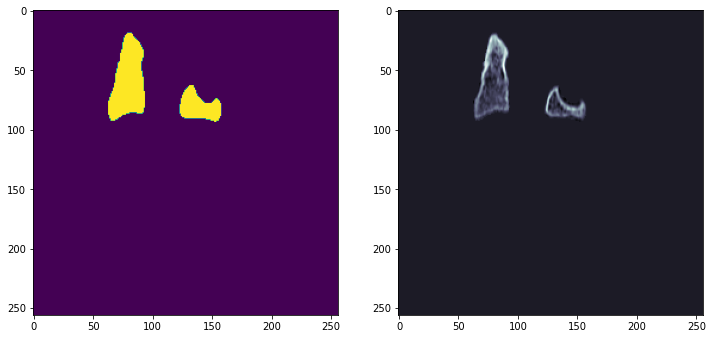

In [20]:
x, mask, y = next(iter(val_loader))
print(y)
sample_index = 11

print("label {}".format(y[sample_index]))

_, axs = plt.subplots(1, 2, figsize=(12, 12))

axs[0].imshow(mask[sample_index, 0, :, :])
axs[1].imshow((x * mask)[sample_index, 0, :, :], cmap='bone')

In [21]:
def loss_fn(logits, y, pos_weight=torch.tensor(1)):
    # labels = F.one_hot(y, num_classes=7).reshape(-1, 1).float()

    loss = F.binary_cross_entropy_with_logits(logits, y, pos_weight=pos_weight)
    return loss


In [22]:
def denormalize_img(x):
    img = x.detach().cpu().numpy()
    img = (img * 0.5) + 0.5
    img = img.transpose(0, 2, 3, 1)
    return img

In [23]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, 2 * self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(2 * self.out_channels, self.n_features, kernel_size=1, padding='same'),
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=1, padding='same'),
            )
            parallel_modules.append(module)

        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i] // 2, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i] // 2, self.channels[i - 1] if i > 0 else self.out_channels, kernel_size=1),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules

    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i + 1)]
            parallel_output = parallel_outputs[-(i + 1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out


def get_seg_backbone():
    backbone = models.resnet50(pretrained=False)
    conv1_weight = backbone.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    backbone.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    channels = [64, 512, 1024, 2048]
    checkpoint = f"checkpoint/{vertical_type}_segmentation_detection_095730-epoch-20.pth"
    seg_model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2).to(device)
    state = torch.load(checkpoint)
    seg_model.load_state_dict(state["model"])
    return seg_model.downsampling_modules, [1, 64, 512, 1024, 2048]


In [24]:
# backbone, channels = get_backbone()
# if backbone == "segmentation":
#     backbone, channels = get_seg_backbone()
# else:
#     backbone, channels = get_backbone()
# model = ClassificationModel(backbone, channels).to(device)

In [25]:
def get_effnet():
    backbone = models.efficientnet_v2_s(pretrained=True)
    
    backbone.classifier[1] = nn.Linear(1280, 1, bias=True)
    return backbone
# model = get_effnet()
# model

In [26]:
# torch.__version__

In [27]:
# model = get_simple_resnet_model()
model = get_effnet()
model = model.to(device)
# model

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
# test_batch_size=16

# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=min(16, batch_size))

# test_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False, pin_memory=False, num_workers=test_batch_size)
# val_iter = iter(val_loader)
x, mask, y = next(iter(val_loader))
print(y)
x = x.to(device)
mask = mask.to(device)
x = x * mask
# mask = mask.to(device)
y = y.to(device).float()

logits = model(x).flatten()
loss = loss_fn(logits, y, pos_weight=torch.tensor(2))
print(loss.item())
pred = logits.sigmoid().ge(0.5).float()
print(y)
print(pred)
acc = (pred == y).float().mean()
print(acc)

del x
del mask
del y

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
0.8032870292663574
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 1., 0., 1.], device='cuda:0')
tensor(0.2969, device='cuda:0')


In [29]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))

In [30]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)


In [31]:
# def apply_mask(x, mask):
    

In [32]:
def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, mask, y) in enumerate(train_iter):
        x = x.to(device)
        mask = mask.to(device)
        x = x * mask
        y = y.to(device).float()

        with torch.cuda.amp.autocast(device == 'cuda'):
            logits = model(x).flatten()
            loss = loss_fn(logits, y, pos_weight=pos_weight)
            acc = (logits.sigmoid().ge(0.5).float() == y).float().mean()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()

        train_iter.set_description(f"t {e} loss {loss.item():.4f} acc {acc.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'train_acc' : acc.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })

        # if i % 10 == 0:
        #     with torch.no_grad():
        #         infer_bad_sample(wandb_log=True)
        #     model.train()

    return np.mean(losses)

In [33]:
@torch.no_grad()
def evaluate(e, model, dataloader):
    model.eval()
    
    eval_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)
    
    eps = 1e-3

    for i, (x, mask, y) in enumerate(eval_iter):
        x = x.to(device)
        mask = mask.to(device)
        x = x * mask
        # mask = mask.to(device)
        y = y.to(device).float()

        logits = model(x).flatten()
        prob = logits.sigmoid()
        prob = prob.clip(min=eps, max=(1 - eps))
        loss = F.binary_cross_entropy(prob, y)
        pred = prob.ge(0.5).float()

        acc = (pred == y).float().mean()
        
        # pick = (pred.long() && y.long()).sum()

        eval_iter.set_description(f"e {e} loss {loss.item():.4f} ecc {acc.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            wandb.log({
                'eval_loss': loss.item(),
                'eval_acc' : acc.item(),
                'epoch': e,
                'eval_iteration': i + e * epoch_iteration,
            })
    return np.mean(losses)

In [34]:
epoch = 0

In [35]:
epochs = 300

evaluate(epoch, model, val_loader)

for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)
    
    eval_loss = evaluate(epoch, model, val_loader)
    
    print(f"train loss {train_loss} eval loss {eval_loss}")
    scheduler.step()
    epoch += 1

e 0 loss 0.3230 ecc 0.8246: 100%|██████████| 73/73 [00:11<00:00,  6.61it/s]


train loss 0.45834703416857003 eval loss 0.2242089044557859


e 1 loss 0.2272 ecc 0.8246: 100%|██████████| 73/73 [00:11<00:00,  6.63it/s]


train loss 0.30036666815819807 eval loss 0.18499868580025353


e 2 loss 0.1505 ecc 0.9298: 100%|██████████| 73/73 [00:10<00:00,  6.68it/s]


train loss 0.23593854516336363 eval loss 0.15719395916755885


e 3 loss 0.1006 ecc 0.9474: 100%|██████████| 73/73 [00:11<00:00,  6.51it/s]


train loss 0.15327843186789997 eval loss 0.1489874806433712


e 4 loss 0.2721 ecc 0.8947: 100%|██████████| 73/73 [00:11<00:00,  6.58it/s]


train loss 0.1138687798983022 eval loss 0.14341741930438232


e 5 loss 0.3596 ecc 0.8772: 100%|██████████| 73/73 [00:10<00:00,  7.04it/s]


train loss 0.10526931840824345 eval loss 0.16156020506336163


e 6 loss 0.1899 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.93it/s]


train loss 0.07464361552480761 eval loss 0.24417357045793522


e 7 loss 0.1352 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.72it/s]


train loss 0.07379653025896939 eval loss 0.2811123972729946


e 8 loss 0.3131 ecc 0.9298: 100%|██████████| 73/73 [00:10<00:00,  6.79it/s]


train loss 0.06248646954619501 eval loss 0.24932176513718568


e 9 loss 0.9736 ecc 0.8596: 100%|██████████| 73/73 [00:10<00:00,  6.66it/s]


train loss 0.19343719369584356 eval loss 0.3275304438501647


e 10 loss 0.5846 ecc 0.8947: 100%|██████████| 73/73 [00:10<00:00,  6.67it/s]


train loss 0.14920167681484225 eval loss 0.2940506519054458


e 11 loss 0.6396 ecc 0.8947: 100%|██████████| 73/73 [00:10<00:00,  6.76it/s]


train loss 0.13739857273210948 eval loss 0.2535061753316693


e 12 loss 0.1936 ecc 0.9474: 100%|██████████| 73/73 [00:10<00:00,  6.77it/s]


train loss 0.12566489644412251 eval loss 0.27226303569806665


e 13 loss 0.3645 ecc 0.9474: 100%|██████████| 73/73 [00:10<00:00,  6.78it/s]


train loss 0.1181696382851599 eval loss 0.2264223459195856


e 14 loss 0.2424 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.73it/s]


train loss 0.1118548334612092 eval loss 0.21007833741477702


e 15 loss 0.3645 ecc 0.9474: 100%|██████████| 73/73 [00:10<00:00,  6.80it/s]


train loss 0.1254390243426719 eval loss 0.2648512675229154


e 16 loss 0.2437 ecc 0.9649: 100%|██████████| 73/73 [00:11<00:00,  6.52it/s]


train loss 0.030259433566668888 eval loss 0.26286958774220043


e 17 loss 0.3645 ecc 0.9474: 100%|██████████| 73/73 [00:10<00:00,  6.84it/s]


train loss 0.037206802157232245 eval loss 0.2487430477798725


e 18 loss 0.2439 ecc 0.9649: 100%|██████████| 73/73 [00:11<00:00,  6.57it/s]


train loss 0.04308407631033313 eval loss 0.23768394931589495


e 19 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.95it/s]


train loss 0.01511754852528499 eval loss 0.24447931547661964


e 20 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.66it/s]


train loss 0.04264630205956302 eval loss 0.24656217041017156


e 21 loss 0.2556 ecc 0.9474: 100%|██████████| 73/73 [00:11<00:00,  6.55it/s]


train loss 0.02146095379922898 eval loss 0.259221700833447


e 22 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:11<00:00,  6.56it/s]


train loss 0.03613319824356793 eval loss 0.2269593530832088


e 23 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.86it/s]


train loss 0.01761635989750445 eval loss 0.23479125873434473


e 24 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.71it/s]


train loss 0.008640266640068494 eval loss 0.2529169730555062


e 25 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.85it/s]


train loss 0.03237170799989989 eval loss 0.22138747029733677


e 26 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.76it/s]


train loss 0.007862931794048142 eval loss 0.2633043700089193


e 27 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.78it/s]


train loss 0.022353237403659253 eval loss 0.2560680901092694


e 28 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.80it/s]


train loss 0.012088989661818872 eval loss 0.24961688629932038


e 29 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:11<00:00,  6.56it/s]


train loss 0.027378173050605113 eval loss 0.30066185295964554


e 30 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.81it/s]


train loss 0.014409379017860017 eval loss 0.25945549531144485


e 31 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.76it/s]


train loss 0.002625592711378996 eval loss 0.24779357788574002


e 32 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:11<00:00,  6.63it/s]


train loss 0.015207198605950094 eval loss 0.22899501778867912


e 33 loss 0.3645 ecc 0.9474: 100%|██████████| 73/73 [00:10<00:00,  6.91it/s]


train loss 0.015285101192877694 eval loss 0.24529211292336758


e 34 loss 0.3645 ecc 0.9474: 100%|██████████| 73/73 [00:11<00:00,  6.63it/s]


train loss 0.019108333641290384 eval loss 0.27468640499186947


e 35 loss 0.1636 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.64it/s]


train loss 0.016750394499718633 eval loss 0.24732943891056444


e 36 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.87it/s]


train loss 0.00989353071860874 eval loss 0.26821772760252327


e 37 loss 0.1629 ecc 0.9649: 100%|██████████| 73/73 [00:11<00:00,  6.54it/s]


train loss 0.017659447294625114 eval loss 0.26585982523839413


e 38 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.69it/s]


train loss 0.0025489848834103646 eval loss 0.22414596880664922


e 39 loss 0.2436 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.64it/s]


train loss 0.009856787954404998 eval loss 0.23703635564035647


e 40 loss 0.5713 ecc 0.9123: 100%|██████████| 73/73 [00:10<00:00,  6.81it/s]


train loss 0.021535312986522705 eval loss 0.27773938250364355


e 41 loss 0.2518 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.82it/s]


train loss 0.0029484416445449374 eval loss 0.2563864615784116


e 42 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.99it/s]


train loss 0.0003150556012650029 eval loss 0.2580672972468812


e 43 loss 0.2433 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.81it/s]


train loss 2.0878040790878716e-08 eval loss 0.26255981248089


e 44 loss 0.2434 ecc 0.9649: 100%|██████████| 73/73 [00:10<00:00,  6.90it/s]


train loss 0.008919406981268472 eval loss 0.24861902840537567


  0%|          | 0/73 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# state = {
#     "model": model.state_dict(),
#     "optimizer": optimizer.state_dict(),
#     "scheduler": scheduler.state_dict(),
#     "epoch": epoch,
# }
# torch.save(state, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth')

wandb: Waiting for W&B process to finish... (success).
